# Time Series Prediction using Random Forest
### Helpful resources:  
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276  
- https://pythondata.com/forecasting-with-random-forests/  
- https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1  

For simplification, the prediction is currently only done on item 7798, 24, 15  
### Content
- Simple Exponential Smoothing  
- Holt Winter  
- Random Forest  

### To Do
- write function for preprocessing + feature creation  
- evaluation with given evaluation function

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing, Holt
import datetime

In [3]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load data
df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('data/orders0206_test.csv', sep='|', parse_dates=['time'])
df_train_small = df_train[df_train["itemID"].isin([7798,24,15])]
# display(df_train_small.head(3))
# df_test = pd.read_csv('data/orders0206_test.csv', sep='|', parse_dates=['time'])

# df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
# df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
# product_prices = df_info['simulationPrice'].to_dict()

# df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

In [5]:
# aggregate sales per day
df_train_small['date'] = [d.date() for d in df_train_small['time']]
df_aggregated = df_train_small.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})

df_test['date'] = [d.date() for d in df_test['time']]
df_aggregated_test = df_test.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})

In [6]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        datetime.date(2018, 6, 1))
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries" not in globals():
        s["itemID"] = prod
        df_timeseries = s
    else:
        s["itemID"] = prod
        df_timeseries = pd.concat([df_timeseries,s], ignore_index=False)

# add 0 sales for missing dates per itemID in test data
for prod in df_aggregated_test.itemID.unique():
    s = df_aggregated_test.loc[df_aggregated_test['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        s.index.max())
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries_test" not in globals():
        s["itemID"] = prod
        df_timeseries_test = s
    else:
        s["itemID"] = prod
        df_timeseries_test = pd.concat([df_timeseries_test,s], ignore_index=False)


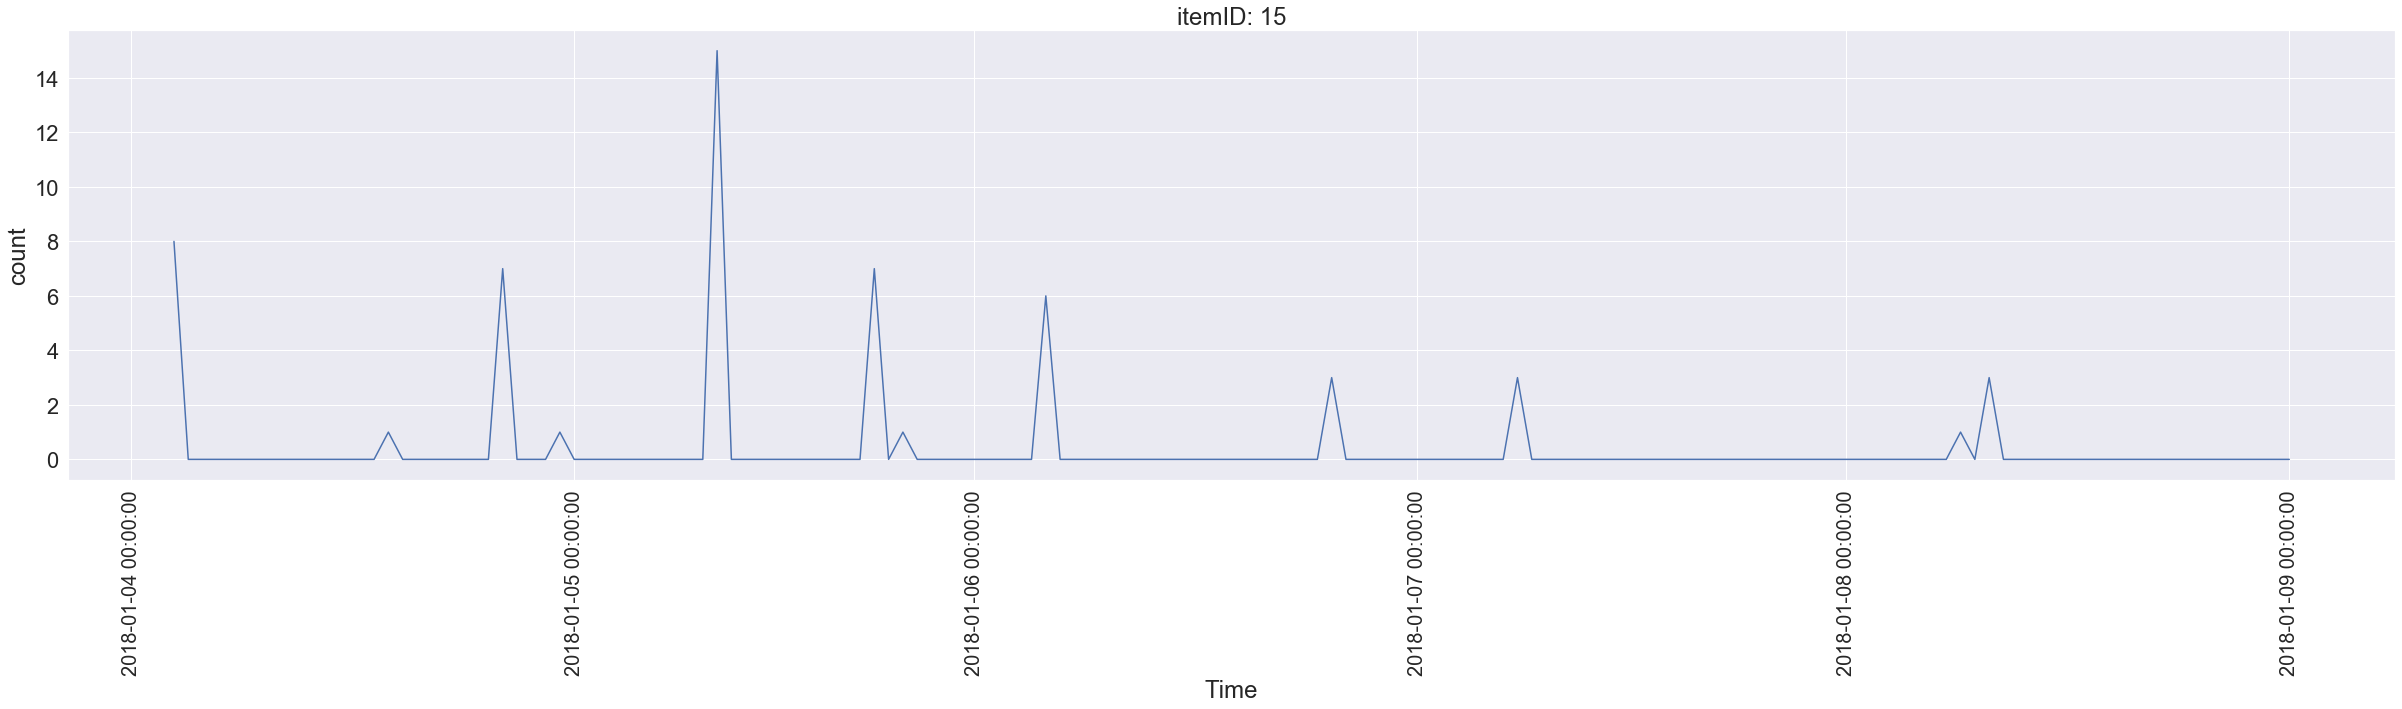

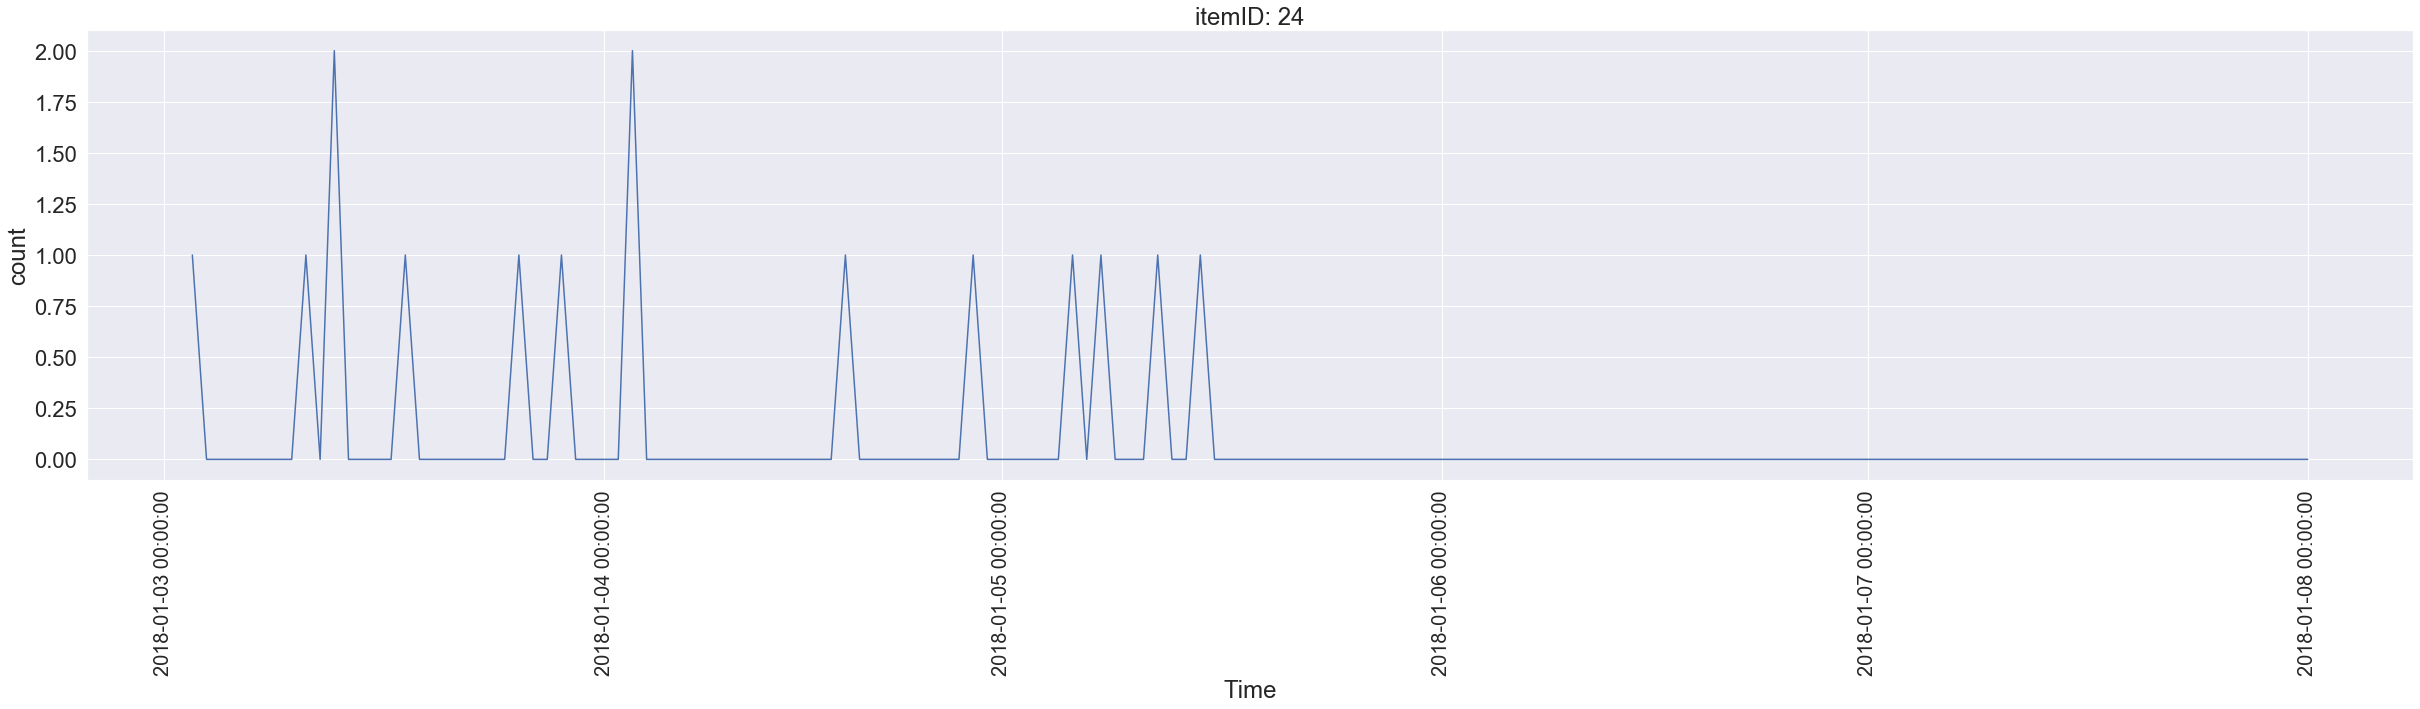

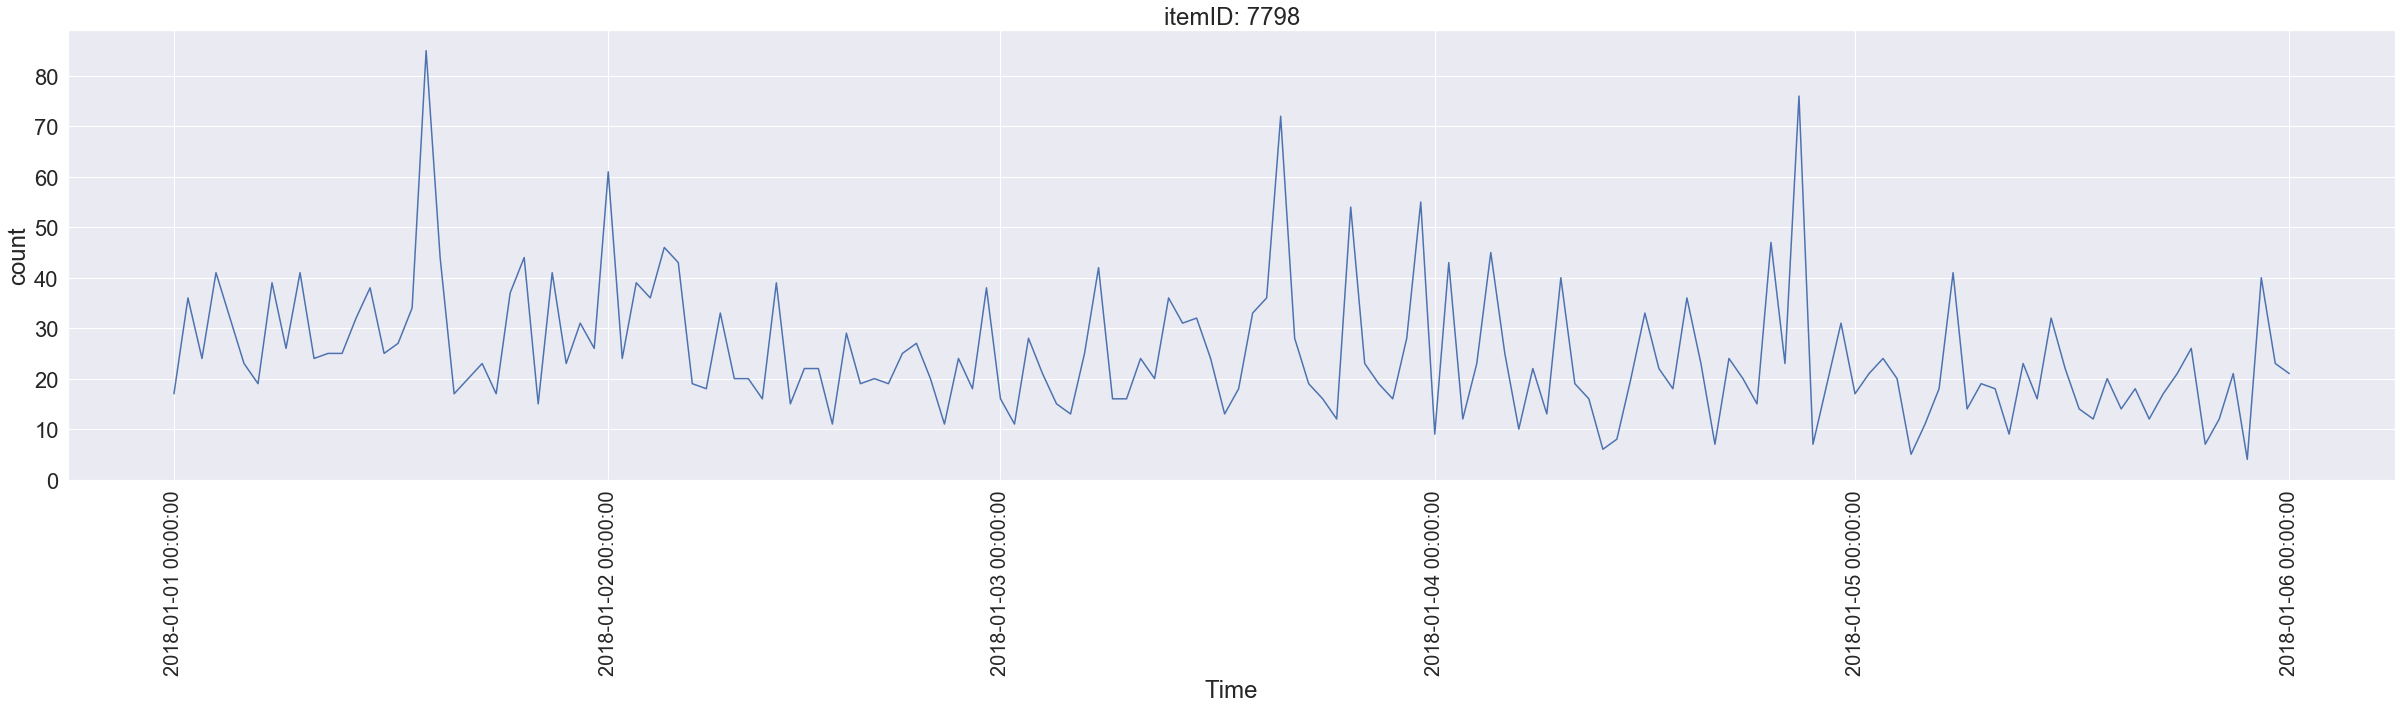

In [7]:
# plot sales of the products
sb.set(rc={'figure.figsize':(41.7,8.27)})
sb.set(font_scale=2)
for prod in df_timeseries.itemID.unique():
    lp = sb.lineplot(data=df_timeseries.loc[df_timeseries['itemID'] == prod], 
                      x=df_timeseries.loc[df_timeseries['itemID'] == prod].index, y='count')
    lp.set(title="itemID: " + str(prod))
    lp.set_xticklabels(df_timeseries.loc[df_timeseries['itemID'] == prod].index, rotation='vertical', fontsize=20)
    lp.set(xlabel='Time', ylabel='count')
    plt.show()

## Simple Exponential Smoothing
https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

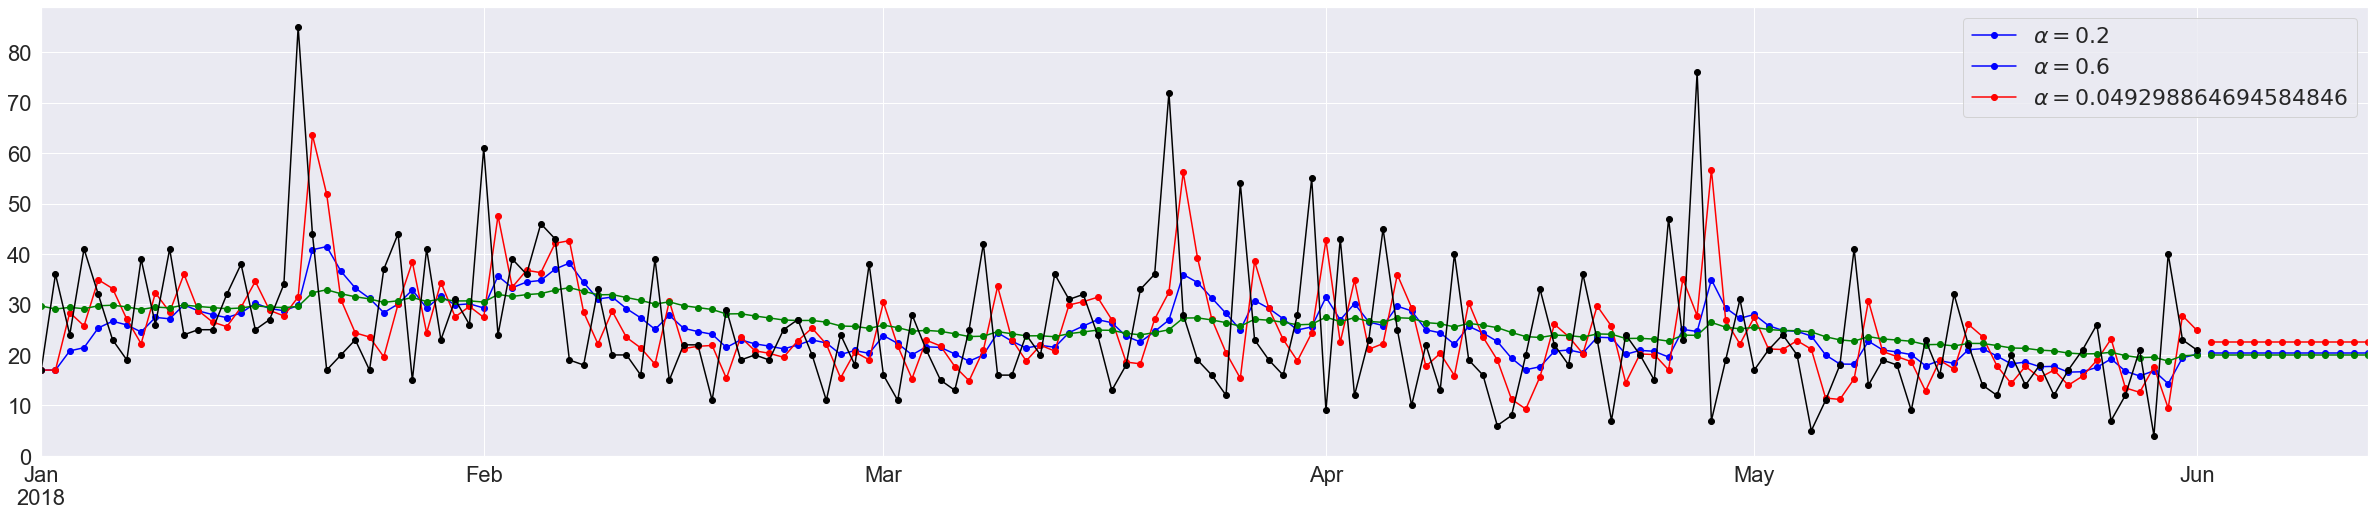

itemID: 7798


In [8]:
# Simple Exponential Smoothing
for prod in [7798]:#df_timeseries.itemID.unique():
    a_data = df_timeseries.loc[df_timeseries['itemID'] == prod]['count']#.array()#.sort_values(by='index', ascending=True)['count'].array
    fit1 = SimpleExpSmoothing(a_data).fit(smoothing_level=0.2,optimized=False)
    fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
    # plot
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')



    fit2 = SimpleExpSmoothing(a_data).fit(smoothing_level=0.6,optimized=False)
    fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
    # plot
    fcast2.plot(marker='o', color='red', legend=True)
    fit2.fittedvalues.plot(marker='o', color='red')


    fit3 = SimpleExpSmoothing(a_data).fit()
    fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
    # plot
    fcast3.plot(marker='o', color='green', legend=True)
    fit3.fittedvalues.plot(marker='o', color='green')
    
    a_data.plot(marker='o', color='black')

    plt.show()
    
    print("itemID: " + str(prod))

## Holt Winter
https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

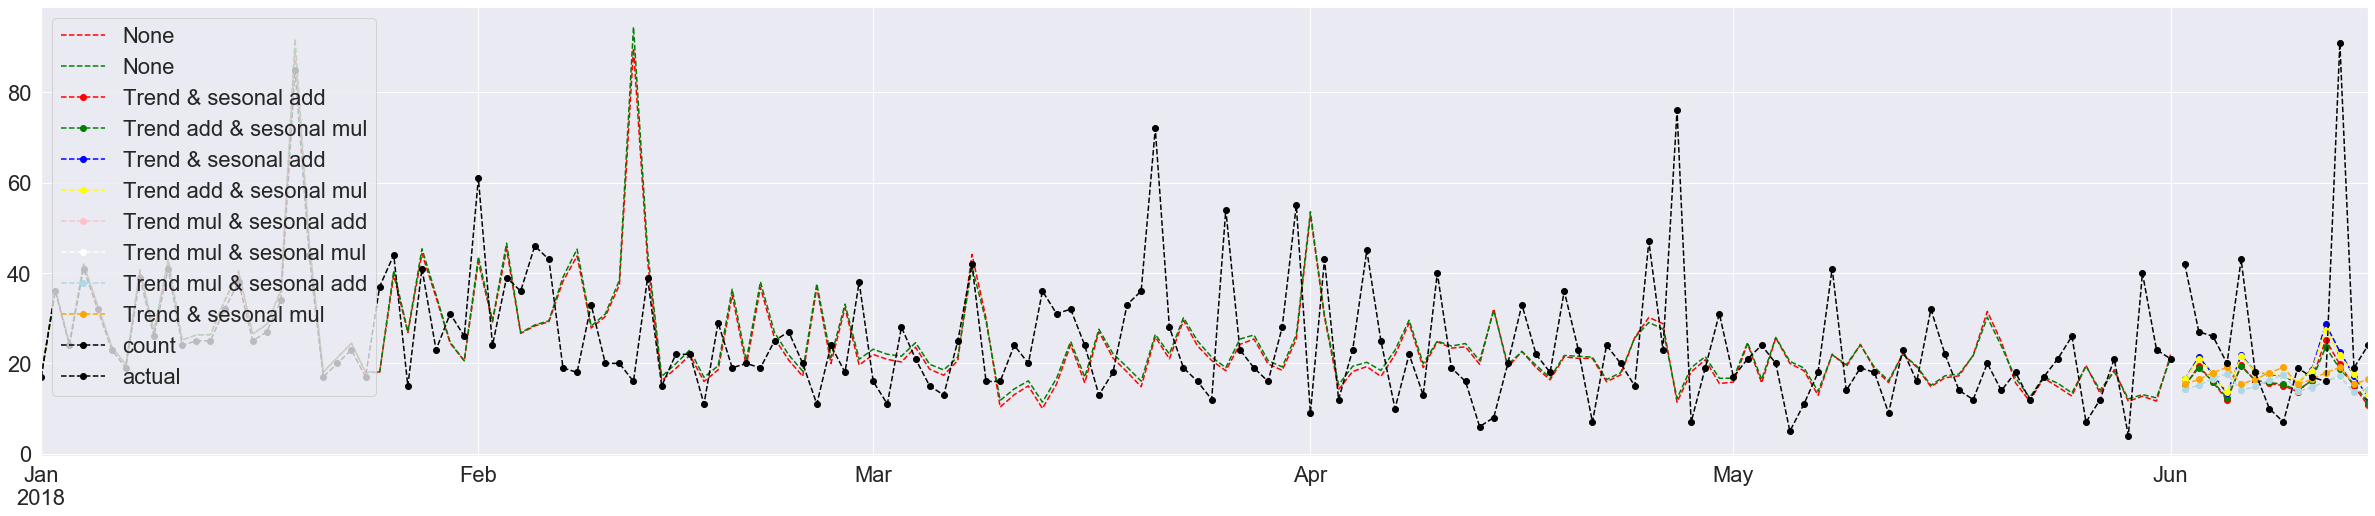

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality. 
itemID: 7798


In [58]:
for prod in [7798]:# df_timeseries.itemID.unique():
    a_data = df_timeseries.loc[df_timeseries['itemID'] == prod]['count']#.array#.sort_values(by='index', ascending=True)['count'].array
    # since data must be positive, add 0.0001 to all numbers
    a_data = a_data + 0.001
    fit1 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='add').fit(use_boxcox=True)
    fit2 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='mul').fit(use_boxcox=True)
    fit3 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
    fit4 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
    fit1.fittedvalues.plot(style='--', color='red')
    fit2.fittedvalues.plot(style='--', color='green')

    fit1.forecast(14).rename("Trend & sesonal add").plot(style='--', marker='o', color='red', legend=True)
    fit2.forecast(14).rename("Trend add & sesonal mul").plot(style='--', marker='o', color='green', legend=True)
    fit3.forecast(14).rename("Trend & sesonal add").plot(style='--', marker='o', color='blue', legend=True)
    fit4.forecast(14).rename("Trend add & sesonal mul").plot(style='--', marker='o', color='yellow', legend=True)
   
    
    fit5 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='mul', seasonal='add').fit(use_boxcox=True)
    fit6 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='mul', seasonal='mul').fit(use_boxcox=True)
    fit7 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='mul', seasonal='add', damped=True).fit(use_boxcox=True)
    fit8 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='mul', seasonal='mul', damped=True).fit(use_boxcox=True)
    fit5.forecast(14).rename("Trend mul & sesonal add").plot(style='--', marker='o', color='pink', legend=True)
    fit6.forecast(14).rename("Trend mul & sesonal mul").plot(style='--', marker='o', color='white', legend=True)
    fit7.forecast(14).rename("Trend mul & sesonal add").plot(style='--', marker='o', color='lightblue', legend=True)
    fit8.forecast(14).rename("Trend & sesonal mul").plot(style='--', marker='o', color='orange', legend=True)
    
    a_data.plot(style='--', marker='o', color='black', legend=True)
    df_timeseries_test.loc[df_timeseries_test['itemID'] == prod]['count'].rename('actual').plot(style='--', marker='o', color='black', legend=True)

    plt.legend(loc='upper left')
    plt.show()
    print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality. \nitemID: " + str(prod))

## Random Forest
https://pythondata.com/forecasting-with-random-forests/  
Needs a format with feature + target.

In [10]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
#     https://datascience.stackexchange.com/questions/24108/multiple-time-series-predictions-with-random-forests-in-python
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

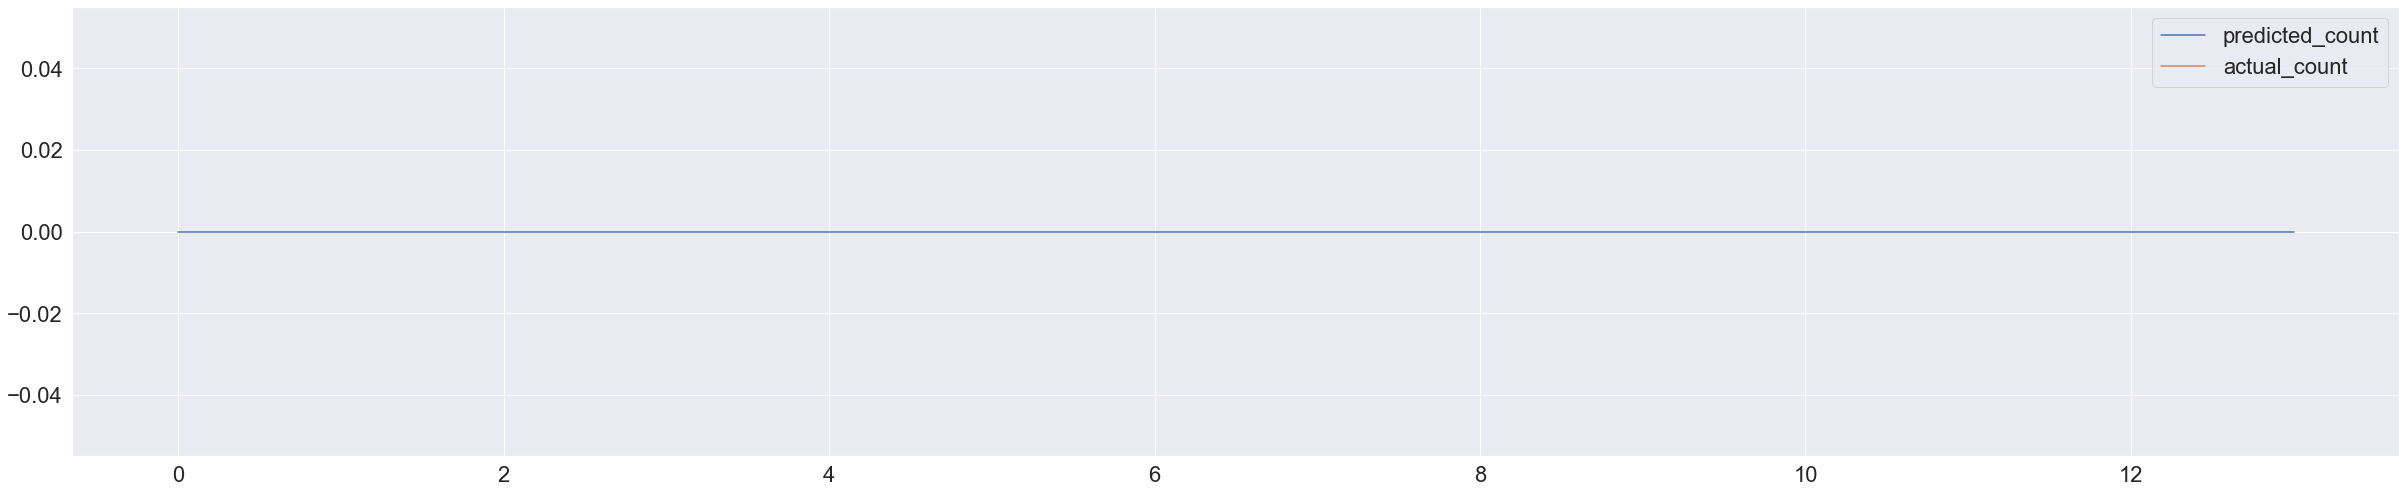

itemID: 15


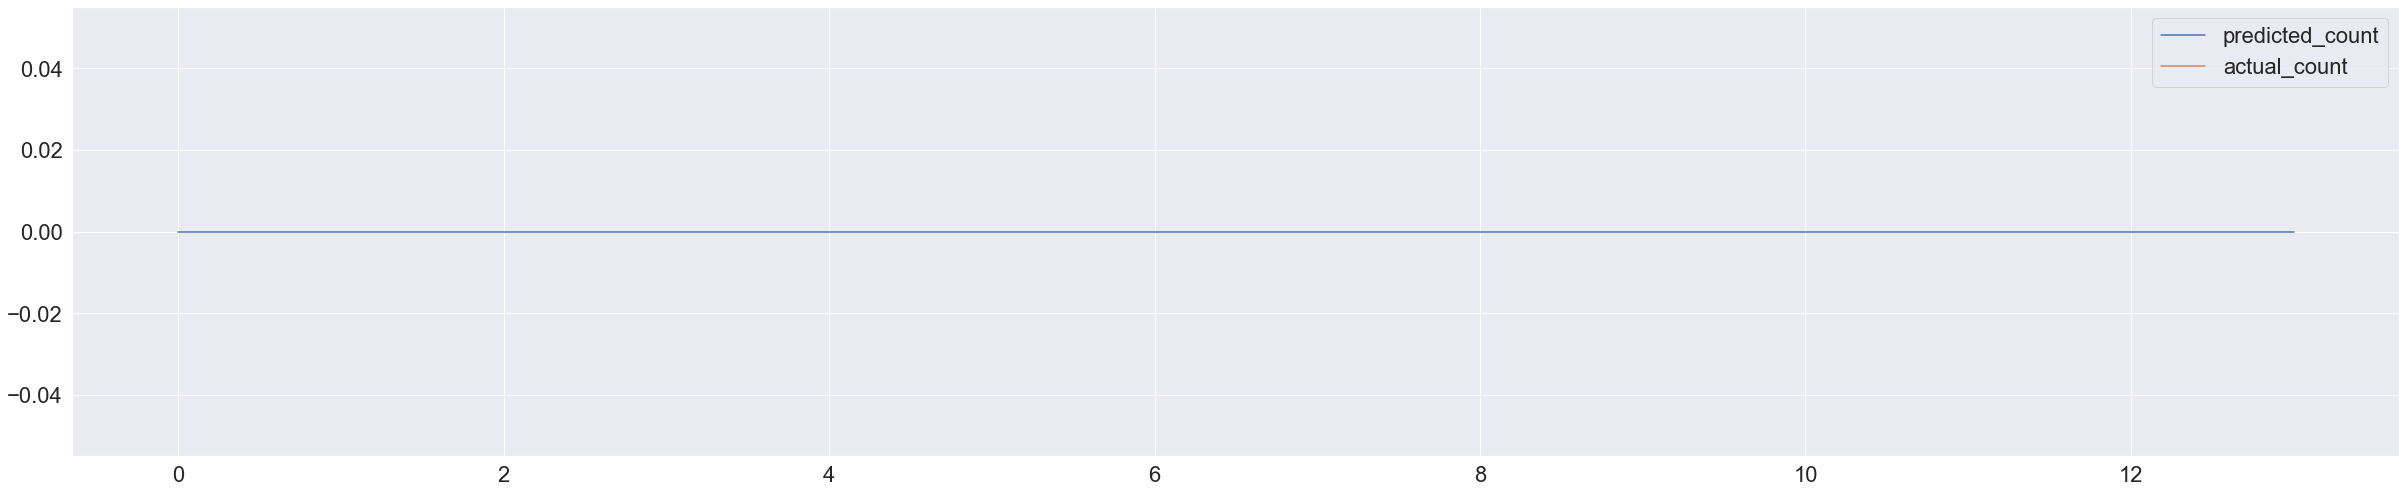

itemID: 24


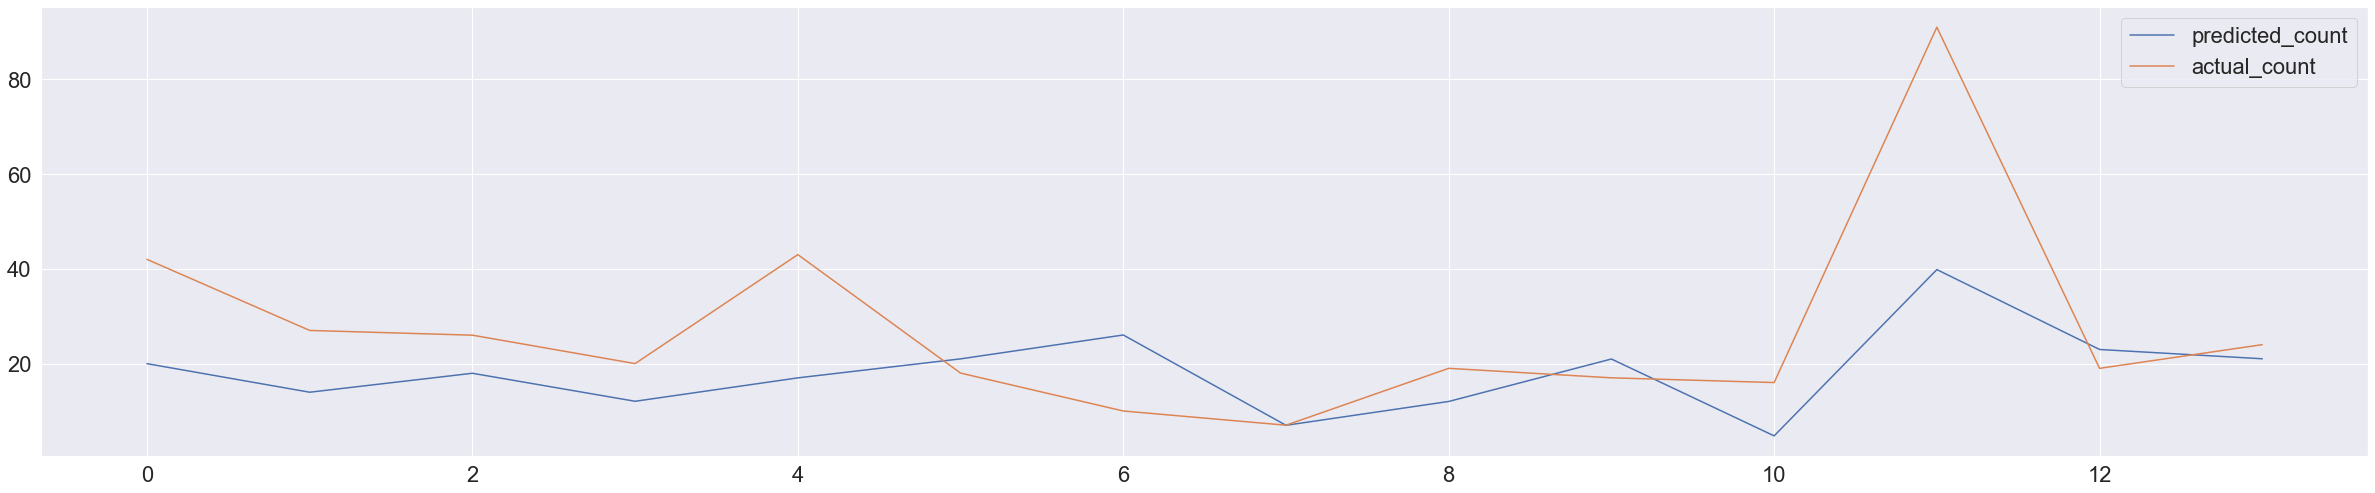

itemID: 7798


In [11]:
for prod in df_timeseries.itemID.unique():
    lag = 7
    
    # get lagged features
    features = table2lags(df_timeseries[df_timeseries['itemID'] == prod][['count']], lag)
#     display(features)
    
    # fit model
    rf = RandomForestRegressor().fit(features[lag:], df_timeseries[df_timeseries['itemID'] == prod]['count'][lag:])
    
    # predict next 2 weeks with previous 2 weeks
    train_predict = pd.DataFrame(rf.predict(features[len(features)-14:])).rename(columns={0:'predicted_count'})
    train_predict["actual_count"] = df_timeseries_test.loc[df_timeseries_test['itemID'] == prod].reset_index()["count"]
#     .tail(        df_timeseries.loc[df_timeseries['itemID'] == prod].size-lag-50)
    
    # plot result
    train_predict.plot()
    plt.show()
    print("itemID: " + str(prod))
#     features.plot()

In [59]:
features

,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7
2018-01-01,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,36,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,24,36.0,17.0,NaN,NaN,NaN,NaN,NaN
2018-01-04,41,24.0,36.0,17.0,NaN,NaN,NaN,NaN
2018-01-05,32,41.0,24.0,36.0,17.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2018-05-28,21,12.0,7.0,26.0,21.0,17.0,12.0,18.0
2018-05-29,4,21.0,12.0,7.0,26.0,21.0,17.0,12.0
2018-05-30,40,4.0,21.0,12.0,7.0,26.0,21.0,17.0
2018-05-31,23,40.0,4.0,21.0,12.0,7.0,26.0,21.0


## Random Forest on all items

In [12]:
# aggregate sales per day
df_train['date'] = [d.date() for d in df_train['time']]
df_aggregated = df_train.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})

In [13]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        datetime.date(2018, 6, 1))
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries_all" not in globals():
        s["itemID"] = prod
        df_timeseries_all = s
    else:
        s["itemID"] = prod
        df_timeseries_all = pd.concat([df_timeseries_all,s], ignore_index=False)

In [14]:
y_randomforest = dict()
for prod in df_timeseries_all.itemID.unique():
    lag = 14
    # ensure proper length 
    if len(df_timeseries_all[df_timeseries_all['itemID'] == prod]) > 28:
    
        # get lagged features
        features = table2lags(df_timeseries_all[df_timeseries_all['itemID'] == prod][['count']], lag)
    #     display(features)

        # fit model
        rf = RandomForestRegressor().fit(features[lag:], df_timeseries_all[df_timeseries_all['itemID'] == prod]['count'][lag:])

        # predict next 2 weeks with previous 2 weeks
        train_predict = pd.DataFrame(rf.predict(features[len(features)-14:])).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = df_timeseries_test.loc[df_timeseries_test['itemID'] == prod].reset_index()["count"]
    #     .tail(        df_timeseries.loc[df_timeseries['itemID'] == prod].size-lag-50)

        # plot result
        y_randomforest[prod] = int(train_predict["predicted_count"].sum().round())
    #     train_predict.plot()
    #     plt.show()
    #     print("itemID: " + str(prod))
    #     features.plot()

In [14]:
from collections import defaultdict

def evaluate_result(y: dict, y_pred: dict):
    monetary_value = 0
    y_pred = defaultdict(int, y_pred)  # return prediction of 0 for items without prediction
    
    for item in set(y_pred).difference(set(y)):
        y[item] = 0  # make sure that all items for which a demand has been predicted are contained in the actual demands
    
    for item, demand in y.items():
        predicted_demand = y_pred[item]
        price = product_prices[item]
        monetary_value += price * min(demand, predicted_demand)
        if predicted_demand > demand:
            monetary_value -= .6 * price * (predicted_demand - demand)
            
    return monetary_value

In [15]:
# actual demand
y = df_test.groupby(by='itemID')['order'].sum().to_dict()

# baseline 1 (average demand of previous 14 days)
y_baseline1 = df_train[df_train['time'] >= '2018-05-19'].groupby(by='itemID')['order'].sum().to_dict()

# baseline 2 (average demand of previous half year)
total_orders = df_train.groupby(by='itemID')['order'].sum().to_dict()
total_observed_days = (df_train['time'].dt.normalize().max() - df_train['time'].dt.normalize().min()).days
y_baseline2 = {item: orders / total_observed_days * 14 for item, orders in total_orders.items()}  # 14-day avg. demand

df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

In [17]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'Random Forest: {evaluate_result(y, y_randomforest):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
Random Forest: -1359513.29


In [18]:
import os
# delete file before we can store it 
os.remove("abraca-data.csv")
# store results
pd.DataFrame(y_randomforest.items()).rename(columns={0:'itemID', 1:"demandPrediction"}).to_csv('abraca-data.csv',index=False, sep='|')

## Holt Winters on all items

In [36]:
y_holtwinters = dict()
for prod in df_timeseries_all.itemID.unique():#[7780,7781,7782,7783,7784,7785,7786,7787,7788, 7789,7790]: #

    a_data = df_timeseries_all.loc[df_timeseries_all['itemID'] == prod]['count']#.array#.sort_values(by='index', ascending=True)['count'].array
    if len(a_data) >= 2:
        # since data must be positive, add 0.0001 to all numbers
        a_data = a_data + 0.001
    #     fit1 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='add').fit(use_boxcox=True)
    #     fit2 = ExponentialSmoothing(a_data, seasonal_periods=6*4, trend='add', seasonal='mul').fit(use_boxcox=True)
        fit3 = ExponentialSmoothing(a_data, seasonal_periods=3, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)

        # plot result
        y_holtwinters[prod] = int(sum(fit3.forecast(14).round().fillna(0)))
        #     train_predict.plot()
        #     plt.show()
        #     print("itemID: " + str(prod))
        #     features.plot()
print(f'Holt Winters: {evaluate_result(y, y_holtwinters):.2f}')

KeyboardInterrupt: 

In [35]:
y_holtwinters

{7780: 0, 7781: 0, 7782: 0, 7783: 0, 7787: 0, 7788: 0, 7789: 19, 7790: 0}

In [ ]:
import os
# delete file before we can store it 
os.remove("abraca-data.csv")
# store results
pd.DataFrame(y_holtwinters.items()).rename(columns={0:'itemID', 1:"demandPrediction"}).to_csv('abraca-data.csv',index=False, sep='|')